# AutoEncoder KMeans

In [1]:
# STEP 1: Build and train an autoencoder on df_scaled

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.decomposition import PCA as SkPCA

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------------------------
# 1) Load / prepare df_scaled
# ------------------------------------------------
try:
    df_scaled
except NameError:
    df_scaled = pd.read_csv("Data/df_scaled.csv")

# Drop index-like column if present
if "Unnamed: 0" in df_scaled.columns:
    df_scaled = df_scaled.drop(columns=["Unnamed: 0"])

print("df_scaled shape:", df_scaled.shape)

feature_cols = list(df_scaled.columns)
X = df_scaled[feature_cols].to_numpy().astype("float32")
print("Feature matrix shape:", X.shape)

df_scaled shape: (10492, 55)
Feature matrix shape: (10492, 55)


Train shape: (8393, 55) Val shape: (2099, 55)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_64 (Dense)            │ (None, 64)             │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_32 (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_32 (Dense)            │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_64 (Dense)            │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 55)             │         3,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,423 (48.53 KB)

 Trainable params: 12,423 (48.53 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7027 - val_loss: 0.5529
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5073 - val_loss: 0.4159
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3814 - val_loss: 0.3313
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3120 - val_loss: 0.2874
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2703 - val_loss: 0.2544
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2427 - val_loss: 0.2344
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2246 - val_loss: 0.2206
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2101 - val_loss: 0.2065
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1971 - val_loss: 0.1968
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1906 - val_loss: 0.1888
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1824 - val_loss: 0.1822
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

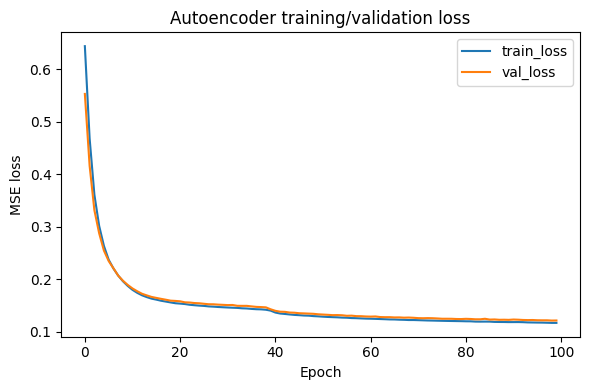

In [2]:
# ------------------------------------------------
# 2) Train/validation split
# ------------------------------------------------
X_train, X_val = train_test_split(
    X,
    test_size=0.2,
    random_state=47,
    shuffle=True,
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

# ------------------------------------------------
# 3) Build the autoencoder
# ------------------------------------------------
input_dim = X.shape[1]
latent_dim = 16  # bottleneck size (you can tweak later)

input_layer = layers.Input(shape=(input_dim,), name="input")

# Encoder
enc = layers.Dense(
    64,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4),
    name="enc_dense_64",
)(input_layer)
enc = layers.Dense(
    32,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4),
    name="enc_dense_32",
)(enc)
latent = layers.Dense(
    latent_dim,
    activation="relu",
    name="latent",
)(enc)

# Decoder
dec = layers.Dense(
    32,
    activation="relu",
    name="dec_dense_32",
)(latent)
dec = layers.Dense(
    64,
    activation="relu",
    name="dec_dense_64",
)(dec)
output_layer = layers.Dense(
    input_dim,
    activation="linear",
    name="reconstruction",
)(dec)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer, name="autoencoder")
encoder = models.Model(inputs=input_layer, outputs=latent, name="encoder")

autoencoder.compile(optimizer="adam", loss="mse")

print(autoencoder.summary())

# ------------------------------------------------
# 4) Train the autoencoder
# ------------------------------------------------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

history = autoencoder.fit(
    X_train,
    X_train,
    validation_data=(X_val, X_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1,
)

# ------------------------------------------------
# 5) Plot training / validation loss
# ------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Autoencoder training/validation loss")
plt.legend()
plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Latent space shape: (10492, 16)
Silhouette scores by k: {2: 0.28506799394402754, 3: 0.18826362488975298, 4: 0.2478904246855709, 5: 0.24904361935889102, 6: 0.2314065591936543, 7: 0.21374278402345312, 8: 0.19618026469041103, 9: 0.19517175386233512, 10: 0.1832927127585732}
Calinski-Harabasz scores by k: {2: 4681.7198939082855, 3: 3485.482514476705, 4: 3789.2315685044937, 5: 3418.436235102537, 6: 3064.618736029286, 7: 2853.8493414905406, 8: 2630.3540224310223, 9: 2527.5376258564006, 10: 2244.130790932993}
Davies-Bouldin scores by k: {2: 1.3950393618709884, 3: 1.7014728152610517, 4: 1.380072725128926, 5: 1.3599925243274718, 6: 1.4809257707866381, 7: 1.4965480057865104, 8: 1.6043016873870721, 9: 1.579151934252091, 10: 1.6909940552521943}


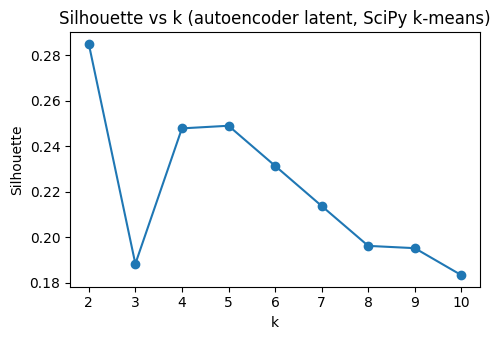

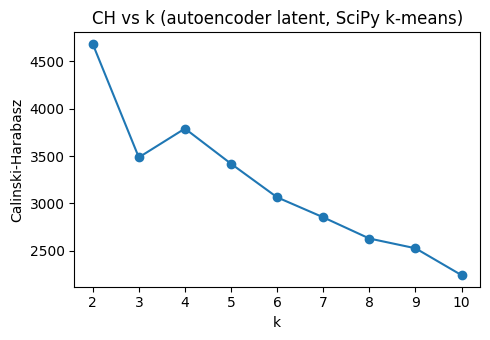

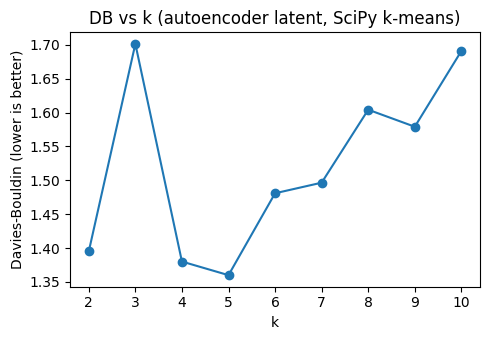

Best k by Silhouette: 2
Final cluster sizes:
cluster_autoenc_kmeans
0    8770
1    1722
Name: count, dtype: int64


In [3]:
# STEP 2: Encode to latent space, run KMeans, compute metrics & visualize

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.vq import kmeans2
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# ------------------------------------------------
# 1) Encode all patients to latent space
# ------------------------------------------------
latent_full = encoder.predict(X, batch_size=256)
print("Latent space shape:", latent_full.shape)

# For SciPy it's safer to use float64
latent_full64 = latent_full.astype(np.float64)

# ------------------------------------------------
# 2) k-means on latent space for k = 2..10 (SciPy)
# ------------------------------------------------
sil_scores = {}
ch_scores = {}
db_scores = {}

ks = range(2, 11)
for k in ks:
    # kmeans2 returns (centroids, labels)
    centroids, labels_k = kmeans2(
        data=latent_full64,
        k=k,
        iter=50,
        minit="++",   # k-means++
    )

    sil_scores[k] = silhouette_score(latent_full64, labels_k, metric="euclidean")
    ch_scores[k]  = calinski_harabasz_score(latent_full64, labels_k)
    db_scores[k]  = davies_bouldin_score(latent_full64, labels_k)

print("Silhouette scores by k:", sil_scores)
print("Calinski-Harabasz scores by k:", ch_scores)
print("Davies-Bouldin scores by k:", db_scores)

# ------------------------------------------------
# 3) Plot metric curves
# ------------------------------------------------
ks_list = sorted(sil_scores.keys())

plt.figure(figsize=(5, 3.5))
plt.plot(ks_list, [sil_scores[k] for k in ks_list], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Silhouette vs k (autoencoder latent, SciPy k-means)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(ks_list, [ch_scores[k] for k in ks_list], marker="o")
plt.xlabel("k")
plt.ylabel("Calinski-Harabasz")
plt.title("CH vs k (autoencoder latent, SciPy k-means)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(ks_list, [db_scores[k] for k in ks_list], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin (lower is better)")
plt.title("DB vs k (autoencoder latent, SciPy k-means)")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 4) Choose best k by Silhouette, compute final labels
# ------------------------------------------------
best_k = max(sil_scores, key=sil_scores.get)
print("Best k by Silhouette:", best_k)

centroids_final, final_labels = kmeans2(
    data=latent_full64,
    k=best_k,
    iter=100,
    minit="++",
)

df_scaled["cluster_autoenc_kmeans"] = final_labels
print("Final cluster sizes:")
print(df_scaled["cluster_autoenc_kmeans"].value_counts().sort_index())



Cluster sizes for k=4:
cluster_autoenc_k4
0    1648
1    3825
2    1417
3    3602
Name: count, dtype: int64


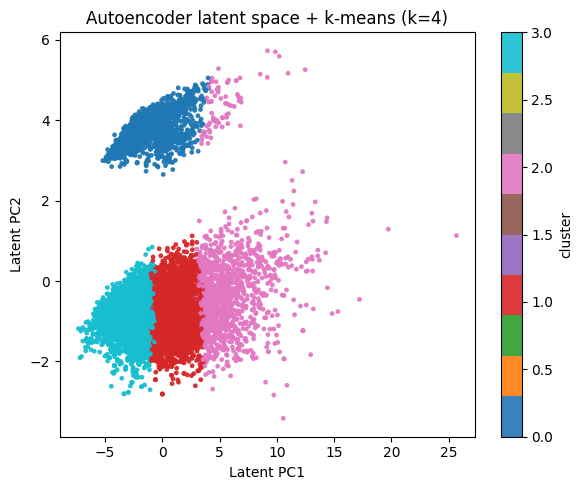

k = 4
Silhouette score     : 0.2470
Calinski–Harabasz    : 3789.27
Davies–Bouldin index : 1.3828

Cluster sizes for k=4:
cluster_autoenc_k4
0    1447
1    3834
2    1648
3    3563
Name: count, dtype: int64


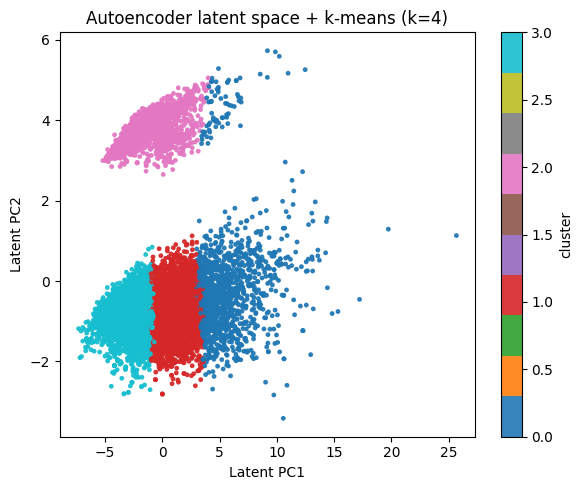

In [4]:
# STEP 3: Inspect k = 4 solution in more detail

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA as SkPCA

# Make sure latent_full64 exists (from previous step)
# latent_full64 = latent_full.astype(np.float64)  # uncomment if needed

k_alt = 4

centroids4, labels4 = kmeans2(
    data=latent_full64,
    k=k_alt,
    iter=100,
    minit="++",
)

df_scaled["cluster_autoenc_k4"] = labels4
print("Cluster sizes for k=4:")
print(df_scaled["cluster_autoenc_k4"].value_counts().sort_index())

# 2D PCA of latent space colored by k=4 clusters
latent_2d_k4 = SkPCA(n_components=2, random_state=47).fit_transform(latent_full64)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    latent_2d_k4[:, 0],
    latent_2d_k4[:, 1],
    c=labels4,
    s=6,
    alpha=0.9,
    cmap="tab10",
)
plt.xlabel("Latent PC1")
plt.ylabel("Latent PC2")
plt.title("Autoencoder latent space + k-means (k=4)")
plt.colorbar(scatter, label="cluster")
plt.tight_layout()
plt.show()


# STEP 3: Inspect k = 4 solution in more detail

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA as SkPCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Make sure latent_full64 exists (from previous step)
# latent_full64 = latent_full.astype(np.float64)  # uncomment if needed

k_alt = 4

centroids4, labels4 = kmeans2(
    data=latent_full64,
    k=k_alt,
    iter=100,
    minit="++",
)

# ---- evaluation metrics for this k=4 solution ----
sil_k4 = silhouette_score(latent_full64, labels4, metric="euclidean")
ch_k4  = calinski_harabasz_score(latent_full64, labels4)
db_k4  = davies_bouldin_score(latent_full64, labels4)

print(f"k = {k_alt}")
print(f"Silhouette score     : {sil_k4:.4f}")
print(f"Calinski–Harabasz    : {ch_k4:.2f}")
print(f"Davies–Bouldin index : {db_k4:.4f}")
# --------------------------------------------------

df_scaled["cluster_autoenc_k4"] = labels4
print("\nCluster sizes for k=4:")
print(df_scaled["cluster_autoenc_k4"].value_counts().sort_index())

# 2D PCA of latent space colored by k=4 clusters
latent_2d_k4 = SkPCA(n_components=2, random_state=47).fit_transform(latent_full64)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    latent_2d_k4[:, 0],
    latent_2d_k4[:, 1],
    c=labels4,
    s=6,
    alpha=0.9,
    cmap="tab10",
)
plt.xlabel("Latent PC1")
plt.ylabel("Latent PC2")
plt.title("Autoencoder latent space + k-means (k=4)")
plt.colorbar(scatter, label="cluster")
plt.tight_layout()
plt.show()


Original k=4 sizes:
cluster_autoenc_k4
0    1447
1    3834
2    1648
3    3563
Name: count, dtype: int64

Subclustering cluster 2 (n=1648) into 2 parts...
  New cluster id 4 size: 1092
  New cluster id 5 size: 556

Subclustering cluster 3 (n=3563) into 2 parts...
  New cluster id 6 size: 2234
  New cluster id 7 size: 1329

Mapping from consecutive id -> original id:
  0 -> 0
  1 -> 1
  2 -> 4
  3 -> 5
  4 -> 6
  5 -> 7

Final refined cluster sizes (consecutive ids):
cluster_autoenc_refined
0    1447
1    3834
2    1092
3     556
4    2234
5    1329
Name: count, dtype: int64


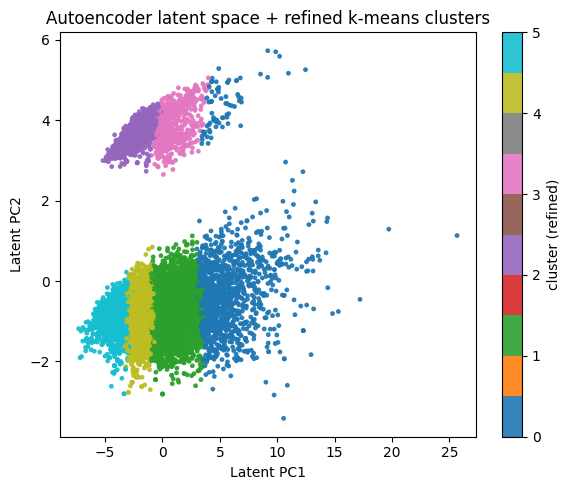

In [5]:
# STEP 4: Subcluster big clusters (2 and 3) and combine them

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA as SkPCA

# Base labels from k=4 solution
base_labels = df_scaled["cluster_autoenc_k4"].to_numpy()
print("Original k=4 sizes:")
print(df_scaled["cluster_autoenc_k4"].value_counts().sort_index())

# We'll refine these two large clusters:
big_clusters = [2, 3]
k_sub = 2  # split each big cluster into 2 subclusters

# Make a copy for refined labels
refined_labels = base_labels.copy()

# Start new cluster IDs after the existing ones (0,1,2,3)
next_id = base_labels.max() + 1  # should start at 4

for c in big_clusters:
    mask = base_labels == c
    indices = np.where(mask)[0]
    data_sub = latent_full64[mask]

    print(f"\nSubclustering cluster {c} (n={data_sub.shape[0]}) into {k_sub} parts...")

    # SciPy k-means within this cluster
    cent_sub, labels_sub = kmeans2(
        data=data_sub,
        k=k_sub,
        iter=100,
        minit="++",
    )

    # Assign new global IDs
    for s in range(k_sub):
        refined_labels[indices[labels_sub == s]] = next_id
        print(f"  New cluster id {next_id} size:", (labels_sub == s).sum())
        next_id += 1

# At this point:
# - original small clusters (0,1) keep their ids
# - big clusters (2,3) have been split into new ids (4,5,6,7)

# For easier plotting, remap to consecutive 0..K-1
unique_ids, refined_consecutive = np.unique(refined_labels, return_inverse=True)

df_scaled["cluster_autoenc_refined"] = refined_consecutive
print("\nMapping from consecutive id -> original id:")
for new_id, old_id in enumerate(unique_ids):
    print(f"  {new_id} -> {old_id}")

print("\nFinal refined cluster sizes (consecutive ids):")
print(df_scaled["cluster_autoenc_refined"].value_counts().sort_index())

# 2D PCA of latent space with refined clusters
latent_2d_ref = SkPCA(n_components=2, random_state=47).fit_transform(latent_full64)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    latent_2d_ref[:, 0],
    latent_2d_ref[:, 1],
    c=df_scaled["cluster_autoenc_refined"],
    s=6,
    alpha=0.9,
    cmap="tab10",
)
plt.xlabel("Latent PC1")
plt.ylabel("Latent PC2")
plt.title("Autoencoder latent space + refined k-means clusters")
plt.colorbar(scatter, label="cluster (refined)")
plt.tight_layout()
plt.show()
